In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
import numpy as np
import pandas as pd
from collections import Counter

# -------------------------
# Implementação da Árvore
# -------------------------
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.tree = None

    def fit(self, X, y):
        self.n_classes = len(set(y))
        self.n_features = X.shape[1] if not self.n_features else self.n_features
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if (depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split):
            return Counter(y).most_common(1)[0][0]

        feat_idxs = np.random.choice(num_features, self.n_features, replace=False)

        # Melhor split
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)
        if best_feat is None:
            return Counter(y).most_common(1)[0][0]

        # Splitar dados
        indices_left = X[:, best_feat] <= best_thresh
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]

        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)
        return (best_feat, best_thresh, left_child, right_child)

    def _best_split(self, X, y, feat_idxs):
        best_gini = 1.0
        best_idx, best_thresh = None, None

        for idx in feat_idxs:
            thresholds = np.unique(X[:, idx])
            for thr in thresholds:
                gini = self._gini_index(y, X[:, idx], thr)
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thresh = thr
        return best_idx, best_thresh

    def _gini_index(self, y, feature_values, threshold):
        left_mask = feature_values <= threshold
        right_mask = ~left_mask
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 1.0

        def gini_group(labels):
            m = len(labels)
            counts = np.bincount(labels)
            return 1.0 - sum((count / m) ** 2 for count in counts if count > 0)

        left_gini = gini_group(y[left_mask])
        right_gini = gini_group(y[right_mask])
        m = len(y)
        return (np.sum(left_mask) / m) * left_gini + (np.sum(right_mask) / m) * right_gini

    def predict(self, X):
        return np.array([self._predict(inputs, self.tree) for inputs in X])

    def _predict(self, inputs, tree):
        if not isinstance(tree, tuple):
            return tree
        feat_idx, threshold, left_child, right_child = tree
        if inputs[feat_idx] <= threshold:
            return self._predict(inputs, left_child)
        else:
            return self._predict(inputs, right_child)

# -------------------------
# Implementação do Random Forest
# -------------------------
class OurRandomForest:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                n_features=self.n_features)
            # Bootstrap sample
            idxs = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[idxs], y[idxs]
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Votação majoritária
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        return np.array([Counter(preds).most_common(1)[0][0] for preds in tree_preds])

# -------------------------
# Exemplo de uso
# -------------------------

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = OurRandomForest(n_trees=10, max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = np.mean(y_pred == y_test)
print(f"Acurácia: {acc:.4f}")


Acurácia: 1.0000


In [22]:
from math import sqrt
from joblib import Parallel, delayed  # opcional: instalar joblib se não tiver

class FastDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, max_features=None, n_classes=None, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.n_classes = n_classes  # se conhecido a priori
        self.tree = None
        self.rng = np.random.default_rng(random_state)

    def fit(self, X, y):
        self.X = X
        self.y = y.astype(int)
        n_samples, n_features = X.shape
        if self.n_classes is None:
            self.n_classes = int(np.max(self.y) + 1)
        if self.max_features is None:
            self.max_features = n_features
        if self.max_features == 'sqrt':
            # padrão similar ao sklearn: sqrt(n_features) para classificação
            self.max_features = max(1, int(sqrt(n_features)))
        # inicia recursão passando índices (evita cópias)
        idxs = np.arange(n_samples, dtype=np.int32)
        self.tree = self._grow_tree(idxs, depth=0)
        # limpa referências grandes se quiser liberar memória: (opcional)
        # del self.X, self.y

    def _grow_tree(self, idxs, depth):
        y = self.y[idxs]
        # nó folha?
        if (self.max_depth is not None and depth >= self.max_depth) \
           or idxs.size < self.min_samples_split \
           or np.unique(y).size == 1:
            # retorna a classe majoritária
            return int(np.bincount(y, minlength=self.n_classes).argmax())

        # amostra características
        n_features = self.X.shape[1]
        feat_idxs = self.rng.choice(n_features, self.max_features, replace=False)

        best_feat, best_thr, best_score, best_left_idx, best_right_idx = self._best_split_vectorized(idxs, feat_idxs)
        if best_feat is None:
            return int(np.bincount(y, minlength=self.n_classes).argmax())

        # cria nó: (feat, thr, left_subtree, right_subtree)
        left = self._grow_tree(best_left_idx, depth + 1)
        right = self._grow_tree(best_right_idx, depth + 1)
        return (int(best_feat), float(best_thr), left, right)

    def _best_split_vectorized(self, idxs, feat_idxs):
        X = self.X
        y = self.y
        m = idxs.size
        if m <= 1:
            return (None, None, None, None, None)

        parent_counts = np.bincount(y[idxs], minlength=self.n_classes)
        parent_gini = 1.0 - np.sum((parent_counts / m) ** 2)

        best_gini = 1.0
        best_feat = None
        best_thr = None
        best_left_idx = None
        best_right_idx = None

        for feat in feat_idxs:
            vals = X[idxs, feat]
            order = np.argsort(vals, kind='mergesort')  # stable sort
            sorted_vals = vals[order]
            sorted_labels = y[idxs][order]

            # posições possíveis: onde valor muda
            diff_positions = np.where(sorted_vals[:-1] != sorted_vals[1:])[0]
            if diff_positions.size == 0:
                continue

            # Para cada classe, construir soma cumulativa (vetorizado por classe)
            # result: (n_classes, m)
            # Se n_classes pequeno, isto é eficiente.
            cum_counts = np.vstack([np.cumsum(sorted_labels == c) for c in range(self.n_classes)])  # shape: (C, m)

            # left_counts for candidate positions (index pos -> left includes indices 0..pos)
            left_counts_at_pos = cum_counts[:, diff_positions]  # shape: (C, n_pos)
            left_totals = np.sum(left_counts_at_pos, axis=0)
            right_counts_at_pos = parent_counts[:, None] - left_counts_at_pos
            right_totals = m - left_totals

            # calcular Gini left and right para cada pos:
            # gini_left = 1 - sum_i (left_counts_i / left_total)^2
            # evitar divide by zero pois diff_positions garante left_totals>0 e right_totals>0
            left_probs_sq = (left_counts_at_pos / left_totals) ** 2
            right_probs_sq = (right_counts_at_pos / right_totals) ** 2

            gini_left = 1.0 - np.sum(left_probs_sq, axis=0)
            gini_right = 1.0 - np.sum(right_probs_sq, axis=0)

            # weighted gini
            weighted_gini = (left_totals / m) * gini_left + (right_totals / m) * gini_right

            # encontra melhor posição nessa feature
            min_pos = np.argmin(weighted_gini)
            min_gini = weighted_gini[min_pos]
            if min_gini < best_gini:
                best_gini = float(min_gini)
                best_feat = feat
                pos = diff_positions[min_pos]
                # threshold entre sorted_vals[pos] e sorted_vals[pos+1] (média)
                best_thr = (sorted_vals[pos] + sorted_vals[pos + 1]) / 2.0
                # reconstrói índices para as duas partições (usando comparação sobre original indices)
                mask_left = X[idxs, feat] <= best_thr
                best_left_idx = idxs[mask_left]
                best_right_idx = idxs[~mask_left]

        return best_feat, best_thr, best_gini, best_left_idx, best_right_idx

    def predict(self, X):
        # prealoca
        preds = np.empty(X.shape[0], dtype=int)
        for i, row in enumerate(X):
            preds[i] = self._predict_one(row, self.tree)
        return preds

    def _predict_one(self, row, node):
        # se folha (int)
        if not isinstance(node, tuple):
            return int(node)
        feat, thr, left, right = node
        if row[feat] <= thr:
            return self._predict_one(row, left)
        else:
            return self._predict_one(row, right)


class FastRandomForest:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, max_features=None,
                 n_jobs=1, random_state=None, n_classes=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.n_classes = n_classes
        self.trees = []

    def _build_one_tree(self, X, y, seed):
        n = len(X)
        # bootstrap via randint
        idxs = np.random.default_rng(seed).integers(0, n, n, dtype=np.int32)
        tree = FastDecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                max_features=self.max_features,
                                n_classes=self.n_classes,
                                random_state=seed)
        tree.fit(X[idxs], y[idxs])
        return tree

    def fit(self, X, y):
        seeds = np.random.SeedSequence(self.random_state).generate_state(self.n_trees)
        # paraleliza construção (opcional)
        if self.n_jobs == 1:
            self.trees = [self._build_one_tree(X, y, int(seeds[i])) for i in range(self.n_trees)]
        else:
            self.trees = Parallel(n_jobs=self.n_jobs)(
                delayed(self._build_one_tree)(X, y, int(seeds[i])) for i in range(self.n_trees)
            )

    def predict(self, X):
        # coleta previsões (n_trees, n_samples)
        all_preds = np.vstack([t.predict(X) for t in self.trees])
        # votação (axis=0 -> por amostra)
        # usar bincount por coluna pode ser lento; fazemos por amostra
        n_samples = X.shape[0]
        final = np.empty(n_samples, dtype=int)
        for i in range(n_samples):
            col = all_preds[:, i]
            final[i] = int(np.bincount(col).argmax())
        return final

In [4]:
from sklearn.ensemble import RandomForestClassifier
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=10, max_depth=5, max_features=None)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = np.mean(y_pred == y_test)
print(f"Acurácia: {acc:.4f}")


Acurácia: 1.0000


In [23]:
import time
### A function to benchmark a implementation of rf:
def benchmark_rf(clf, X, y, n_tests=5, test_size=0.3):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    accuracies = []
    train_times = []
    test_times = []
    for i in range(n_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        model = clf
        
        ### Training
        start = time.time()
        model.fit(X_train, y_train)
        train_times.append(time.time() - start)
        
        ### Testing
        start = time.time()
        y_pred = model.predict(X_test)
        test_times.append(time.time() - start)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        
    
    return pd.DataFrame({
        'implementation': [clf.__class__.__name__]*n_tests,
        'n_features': [X.shape[1]]*n_tests,
        'n_samples': [X.shape[0]]*n_tests,
        'seed': list(range(n_tests)),
        'accuracy': accuracies,
        'train_time': train_times,
        'test_time': test_times})

In [25]:
from tqdm import trange
from sklearn.datasets import make_classification

results = pd.DataFrame()

for i in trange(100,1000, 100):
    # Create syntetic dataset using scikit with i features and 500 samples
    data = make_classification(n_samples=100, n_features=i, n_informative=int(i*0.5), n_redundant=int(i*0.25), n_clusters_per_class=2, random_state=42)
    X, y = data
    results = pd.concat([pd.concat([benchmark_rf(FastRandomForest(n_trees=100, max_depth=10, max_features=None), X, y),
    benchmark_rf(RandomForestClassifier(n_estimators=100, max_depth=10, max_features=None), X, y)]), results], ignore_index=True)


100%|██████████| 9/9 [11:50<00:00, 78.92s/it] 


In [26]:
results.to_csv('results/results_v03.csv', index=False)

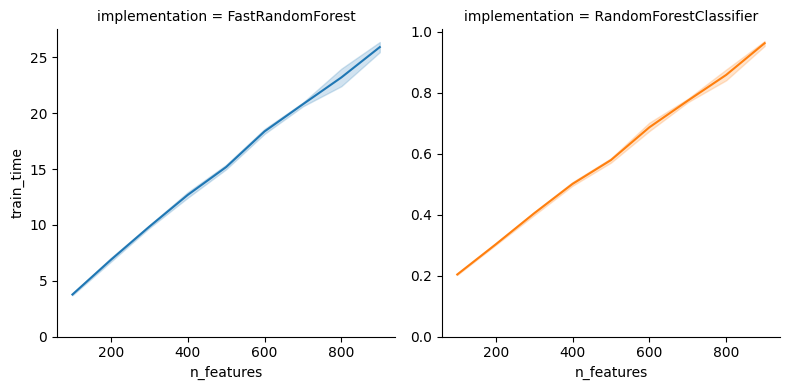

In [31]:
import seaborn as sns

results = pd.read_csv('results/results_v03.csv')
g = sns.FacetGrid(data = results, col='implementation', sharey=False, height=4, hue='implementation')
g.map(sns.lineplot, 'n_features', "train_time")

# Ensure each facet's y-axis starts at 0
for ax in g.axes.flatten():
    ax.set_ylim(bottom=0)


(0.0, 27.75745182001591)

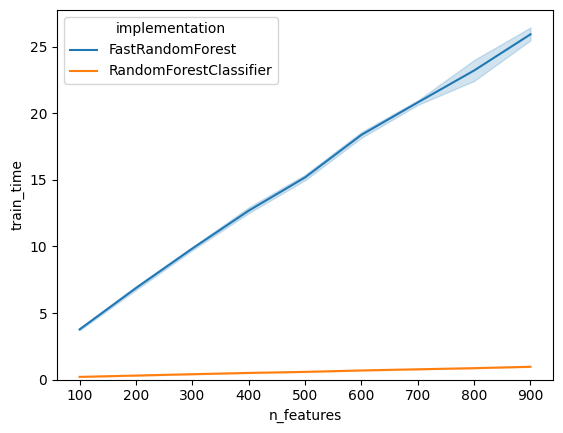

In [28]:
sns.lineplot(data =results, x='n_features', y='train_time', hue='implementation').set_ylim(bottom=0)

In [14]:
results

,implementation,n_features,n_samples,seed,accuracy,train_time,test_time
0,FastRandomForest,3000,100,0,0.600000,2.417582,0.003213
1,FastRandomForest,3000,100,1,0.400000,2.359720,0.003322
2,FastRandomForest,3000,100,2,0.433333,2.399051,0.003169
3,FastRandomForest,3000,100,3,0.300000,2.307048,0.003230
4,FastRandomForest,3000,100,4,0.466667,2.332753,0.003204
...,...,...,...,...,...,...,...
295,RandomForestClassifier,100,100,0,0.633333,0.203967,0.004255
296,RandomForestClassifier,100,100,1,0.500000,0.215586,0.004120
297,RandomForestClassifier,100,100,2,0.666667,0.204358,0.004149
298,RandomForestClassifier,100,100,3,0.600000,0.205476,0.004185


(0.0, 0.7119999999999999)

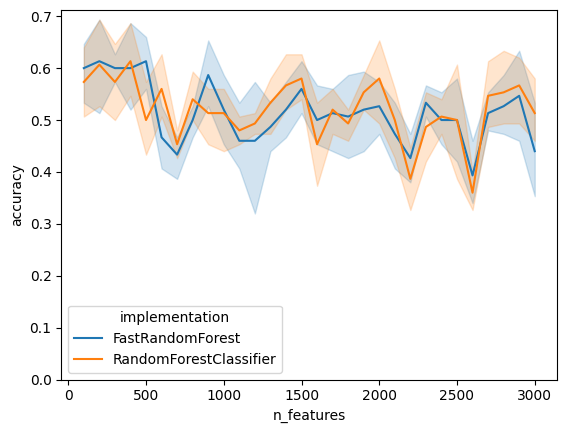

In [17]:
sns.lineplot(data =results, x='n_features', y='accuracy', hue='implementation').set_ylim(bottom=0)

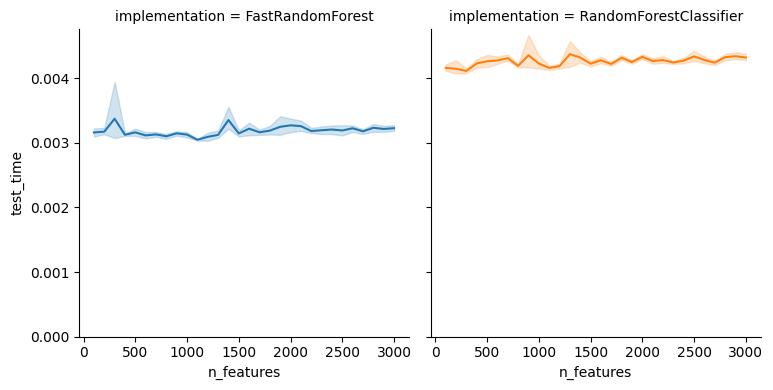

In [18]:
import seaborn as sns

g = sns.FacetGrid(data = results, col='implementation', sharey=True, height=4, hue='implementation')
g.map(sns.lineplot, 'n_features',"test_time")

for ax in g.axes.flatten():
    ax.set_ylim(bottom=0.0)

<Axes: >

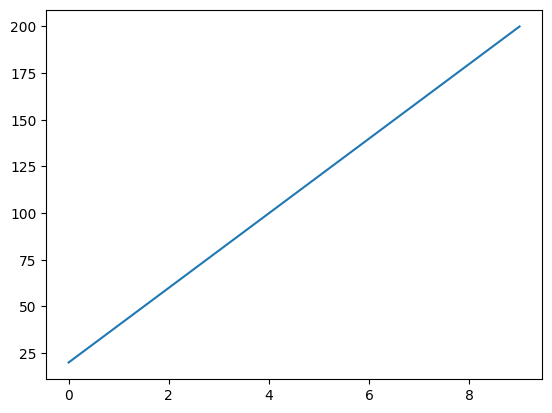

In [9]:
sns.lineplot([20 +20*i for i in range(10)])